In [734]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [735]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from scipy.optimize import linear_sum_assignment

In [736]:
from scipy.optimize import brentq
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

def eer(scores, labels, pos_label=1):
    far, tpr, thresholds = roc_curve(labels, scores, pos_label=pos_label)
    frr = 1 - tpr
    eer = brentq(lambda x: 1.0 - x - interp1d(far, tpr)(x), 0.0, 1.0)
    thresh = interp1d(far, thresholds)(eer)
    return eer, thresh

def far_at_frr(scores, labels, frr_point=1, pos_label=1):
    far, tpr, thresholds = roc_curve(labels, scores, pos_label=pos_label)
    # frr = 1 - tpr
    idx = np.searchsorted(tpr, 1 - (frr_point / 100))
    thresh = thresholds[idx]
    far_point = far[idx]
    return far_point * 100, thresh


In [737]:
def compute_jer(y_hypothesis, y_reference, neg_label=-1):
    classes_pred = [c for c in np.unique(y_hypothesis) if c!=neg_label]
    classes_true = [c for c in np.unique(y_reference) if c!=neg_label]
    n_classes_pred = len(classes_pred)
    n_classes_true = len(classes_true)
    cost_matrix = np.zeros((n_classes_true, n_classes_pred))
    for i, c_true in enumerate(classes_true):
        for j, c_pred in enumerate(classes_pred):
            mask_pred = y_hypothesis==c_pred
            mask_true = y_reference==c_true
            cost_matrix[i,j] = 1 - jaccard_score(mask_true, mask_pred)
    true_inds, pred_inds = linear_sum_assignment(cost_matrix)
    jers = np.ones(n_classes_true)
    for (i, j) in zip(true_inds, pred_inds):
        jers[i] = cost_matrix[i, j]
    JER = np.mean(jers)
    return JER*100

# Generate data

In [826]:
seed = 0
np.random.seed(seed)

cluster_std = 0.5

n_samples = 100
X, y = make_blobs(n_samples=n_samples, centers=3, cluster_std=cluster_std, random_state=seed)

X_adapt, X_test, y_adapt, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

X_unk_adapt, y_unk_adapt = make_blobs(n_samples=n_samples, centers=5, cluster_std=cluster_std, random_state=seed+4)
X_unk_test, y_unk_test = make_blobs(n_samples=n_samples, centers=5, cluster_std=cluster_std, random_state=seed+2)
X_unk_shared, y_unk_shared = make_blobs(n_samples=n_samples, centers=2, cluster_std=cluster_std, random_state=seed+6)

In [827]:
X_adapt = np.r_[X_adapt, X_unk_adapt, X_unk_shared]
y_adapt = np.r_[y_adapt, 0*y_unk_adapt-1, 0*y_unk_shared-1]

X_test = np.r_[X_test, X_unk_test, X_unk_shared]
y_test = np.r_[y_test, 0*y_unk_test-1, 0*y_unk_shared-1]

idx_sort = np.argsort(y_test)
X_test = X_test[idx_sort]
y_test = y_test[idx_sort]

# Data visualization: adaptation and test sets

Both adaptation and test sets may include data points from an "unknown class" labeled as '-1'.

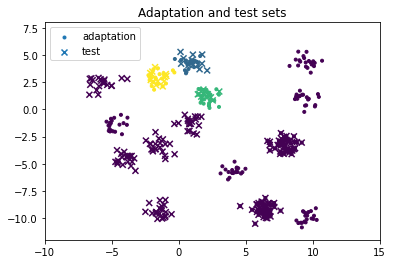

In [828]:
plt.scatter(X_adapt[:, 0], X_adapt[:, 1], c=y_adapt, marker='.', label='adaptation');
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', label='test');
plt.xlim(-10, 15);
plt.ylim(-12, 8);
plt.legend();
plt.title('Adaptation and test sets');
#plt.savefig(f"adaptation_and_test.png", dpi=300, bbox_inches='tight')

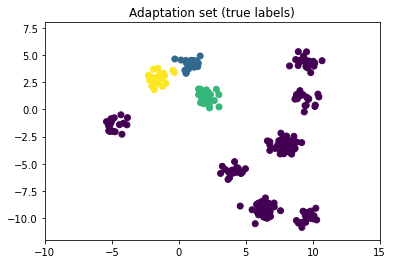

In [829]:
plt.scatter(X_adapt[:, 0], X_adapt[:, 1], c=y_adapt);
plt.xlim(-10, 15);
plt.ylim(-12, 8);
plt.title('Adaptation set (true labels)');
#plt.savefig(f"adaptation.png", dpi=300, bbox_inches='tight')

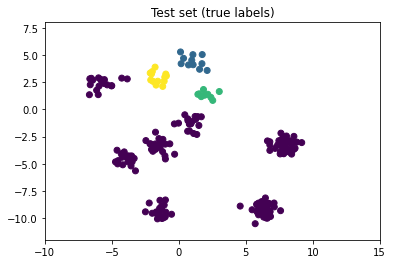

In [830]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);
plt.xlim(-10, 15);
plt.ylim(-12, 8);
plt.title('Test set (true labels)');
#plt.savefig(f"test.png", dpi=300, bbox_inches='tight')

# Clustering

In [831]:
n_clusters = 22

cluster_model = KMeans(n_clusters=n_clusters, random_state=seed)
y_adapt_pred = cluster_model.fit_predict(X_adapt)

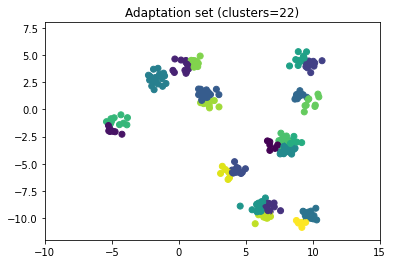

In [832]:
plt.scatter(X_adapt[:, 0], X_adapt[:, 1], c=y_adapt_pred);
plt.xlim(-10, 15);
plt.ylim(-12, 8);
plt.title(f'Adaptation set (clusters={n_clusters})');
#plt.savefig(f"adaptation_clusters_{n_clusters}.png", dpi=300, bbox_inches='tight')

In [833]:
centroids = cluster_model.cluster_centers_

In [834]:
scores_matrix = []
for x in X_test:
    scores = -1 * cdist(centroids, x.reshape(1, -1), 'euclidean').ravel()
    scores_matrix += [scores]
scores_matrix = np.array(scores_matrix)
scores_matrix.shape

(233, 22)

# Evaluation

## Approach 1: use any clustering related measure (Jaccard error rate, JER, in our case) to compare the predicted and the ground-truth partitions.

In [835]:
# detection threshold
threshold = -2

y_pred = []
for i in range(scores_matrix.shape[0]):
    scores = scores_matrix[i, :].ravel()
    cluster_id = np.argmax(scores)
    if scores[cluster_id] < threshold:
        y_pred += [-1]
    else:
        y_pred += [cluster_id]
y_pred = np.array(y_pred)

In [836]:
len(np.unique(y_pred))

14

In [837]:
JER = compute_jer(y_pred, y_test)
JER

15.824915824915827

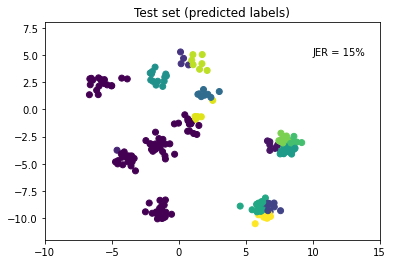

In [838]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred);
plt.xlim(-10, 15);
plt.ylim(-12, 8);
plt.text(10, 5, f'JER = {int(JER)}%')
plt.title('Test set (predicted labels)');
#plt.savefig(f"test_clusters_{n_clusters}_jer_{int(JER)}.png", dpi=300, bbox_inches='tight')

## Approach 2: assume that we have access to true labes for the adaptation set, and measure "generalized FAR and FRR".

In [839]:
n_classes = len(np.unique(y_test[y_test>=0]))
print("Known classes number:", n_classes)

Known classes number: 3


In [840]:
I = np.eye(n_classes)
classes, yy = np.unique(y_test, return_inverse=True)

Y_test = []

for c in y_test:
    soft_one_hot = np.zeros((n_classes + 1,))
    if c == -1:
        soft_one_hot[-1] = 1
    else:
        soft_one_hot[c] = 1
    Y_test += [soft_one_hot.reshape(1, -1)]
Y_test = np.concatenate(Y_test)

In [841]:
Y_adapt_pred = []

for c in np.unique(y_adapt_pred):
    mask = y_adapt_pred == c
    cluster_size = np.sum(mask)
    within_cluster_labels = y_adapt[mask]
    within_cluster_labels_unique, counts = np.unique(within_cluster_labels, return_counts=True)
    soft_one_hot = np.zeros((n_classes + 1,))
    for i, c in enumerate(within_cluster_labels_unique):
        if c == -1:
            soft_one_hot[-1] = 1
        else:
            soft_one_hot[c] = counts[i] / cluster_size
            soft_one_hot[-1] = 1 - np.sum(counts) / cluster_size
    Y_adapt_pred += [soft_one_hot.reshape(1, -1)]
Y_adapt_pred = np.concatenate(Y_adapt_pred)

In [842]:
label_dist_matrix = np.zeros((Y_test.shape[0], Y_adapt_pred.shape[0]))
for i, y1 in enumerate(Y_test):
    for j, y2 in enumerate(Y_adapt_pred):
        label_dist_matrix[i, j] = np.abs(y1 - y2).sum()
label_dist_matrix.shape

(233, 22)

In [843]:
mask_known = y_test>=0

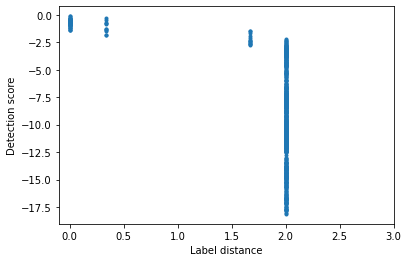

In [844]:
plt.scatter(label_dist_matrix[mask_known, :].ravel(), scores_matrix[mask_known, :].ravel(), marker='.');
plt.xlim(-0.1, 3);
plt.xlabel("Label distance");
plt.ylabel("Detection score");

In [845]:
# label distance threshold
threshold_label_dist = 0.5

scores = scores_matrix[mask_known, :].ravel()
labels = label_dist_matrix[mask_known, :].ravel() < threshold_label_dist

assert 0 < np.mean(labels) < 1, f"targets: {np.sum(labels==1)}, non-targets: {np.sum(labels==0)}"

frr_point = 1

EER = eer(scores, labels)[0] * 100
FAR = far_at_frr(scores, labels, frr_point=frr_point)[0]

print(f"EER: {EER:.2f} %")
print(f"FAR@FRR={frr_point}: {FAR:.2f} %")

EER: 0.45 %
FAR@FRR=1: 0.45 %
